In [139]:
import pandas as pd
import json
from collections import defaultdict
import numpy as np
from tqdm.notebook import tqdm_notebook as tqdm

In [3]:
with open('./tmp.json') as f:
    concepts = json.load(f)
concepts.keys()

dict_keys(['name', 'language', 'title', 'description', 'author', 'license', 'created', 'resources', 'ddfSchema'])

In [39]:
counter = defaultdict(lambda :0)
appear = defaultdict(lambda :[])
for resource in concepts['resources'][1:]:
    r_name = resource['name']
    for d in resource['schema']['fields']:
        counter[d['name']] += 1
        appear[d['name']].append(r_name)
cnt2ind = defaultdict(lambda: [])
for k, v in counter.items():
    cnt2ind[v].append(k)
for cnt in sorted(cnt2ind.keys()):
    print(cnt, cnt2ind[cnt])

1 ['abscorrup_idea', 'ajustice_idea', 'bwelfr_idea', 'c_checkgvt_idea', 'c_civsocpart_idea', 'c_demox_eiu', 'c_dirdemo_idea', 'c_elecparti_idea', 'c_fundright_idea', 'c_impadmin_idea', 'c_locdemo_idea', 'c_rgvt_idea', 'celec_idea', 'checkgvt_idea', 'civlibx_eiu', 'civsocpart_idea', 'cliberities_fh', 'cliberties_idea', 'compt_plastic_wst', 'demox_eiu', 'dirdemo_idea', 'efparlt_idea', 'elecparti_idea', 'electoplx_eiu', 'elgov_idea', 'emigrant_n', 'emigrant_pc', 'fassoas_idea', 'female_hos', 'fexpression_idea', 'fmvt_idea', 'fppart_idea', 'freedix_fh', 'freedstatus_fh', 'freligion_idea', 'fundright_idea', 'gendereq_idea', 'gini', 'gvtx_eiu', 'ihme_cardio_death', 'ihme_conflict_death', 'ihme_hiv_death', 'ilevels3_wb', 'ilevels4_wb', 'immigrant_n', 'immigrant_pc', 'impadmin_idea', 'isuffrage_idea', 'judicindep_idea', 'locdemo_idea', 'mediaint_idea', 'ndisasd_noep_rate', 'ndisasd_noep_tot', 'ndisasd_rate', 'ndisasd_tot', 'num_countries_fhos', 'percit_1_5m', 'percit_300_500k', 'percit_500k_1m

In [40]:
nations = pd.read_json('../public/nations.json')
nations

,name,region,income,population,lifeExpectancy
0,Angola,Sub-Saharan Africa,"[[1800, 359.93], [1820, 359.93], [1913, 556.12...","[[1800, 1567028], [1820, 1567028], [1940, 3738...","[[1800, 26.98], [1940, 26.98], [1950, 29.22], ..."
1,Benin,Sub-Saharan Africa,"[[1800, 553.72], [1820, 553.72], [1913, 855.53...","[[1800, 636559], [1820, 636559], [1950, 167266...","[[1800, 31], [1944, 31], [1950, 36.53], [1951,..."
2,Botswana,Sub-Saharan Africa,"[[1800, 407.36], [1820, 407.36], [1913, 629.4]...","[[1800, 121000], [1904, 121000], [1911, 125000...","[[1800, 33.6], [1945, 33.6], [1950, 46.82], [1..."
3,Burkina Faso,Sub-Saharan Africa,"[[1800, 454.33], [1820, 454.33], [1913, 497.44...","[[1800, 1665421], [1820, 1665421], [1950, 4376...","[[1800, 29.2], [1945, 29.2], [1950, 32.89], [1..."
4,Burundi,Sub-Saharan Africa,"[[1800, 447.59], [1820, 447.59], [1913, 353.82...","[[1800, 899097], [1820, 899097], [1950, 236252...","[[1800, 31.5], [1945, 31.5], [1950, 38.42], [1..."
...,...,...,...,...,...
175,Timor-Leste,East Asia & Pacific,"[[1800, 514.12], [1820, 518.73], [1850, 539.86...","[[1800, 137262], [1820, 137262], [1926, 442000...","[[1950, 28.97], [1951, 29.22], [1952, 29.73], ..."
176,Tokelau,East Asia & Pacific,"[[2005, 889.43]]","[[1800, 1009], [1843, 1000], [1850, 1000], [19...","[[2006, 69]]"
177,Tonga,East Asia & Pacific,"[[1800, 667.71], [1820, 667.71], [1913, 902.69...","[[1800, 18658], [1843, 18500], [1850, 18500], ...","[[1950, 57.91], [1951, 58.1], [1952, 58.47], [..."
178,Vietnam,East Asia & Pacific,"[[1800, 459.71], [1820, 459.71], [1870, 440.8]...","[[1800, 6551000], [1820, 6551000], [1870, 1052...","[[1800, 32], [1930, 32], [1936, 33], [1950, 39..."


In [191]:
inds = 'name year region income population lifeExpectancy'.split()
new_nations = pd.DataFrame({k: [] for k in inds}, index=[])
for nation in tqdm(nations.iterrows(), total=len(nations)):
    d = defaultdict(lambda: {k: None for k in inds[3:]})
    for k in inds[3:]:
        for year, v in nation[1][k]:
            d[year][k] = v
    for year in range(1800, 2010):
        d_tmp = dict(name=nation[1]['name'], year=year, region=nation[1]['region'])
        d_tmp.update(d[year])
        new_nations = new_nations.append(d_tmp, ignore_index=True)
new_nations = new_nations.astype({'name': str, 'year': int, 'region': str, 'income': float, 'population': float, 'lifeExpectancy': float})
new_nations['year'] = pd.to_datetime(new_nations['year'], format='%Y')
new_nations_ = new_nations.set_index(['name', 'year'])
new_nations__ = new_nations.set_index(['name', 'year', 'region'])
new_nations__

income  population  lifeExpectancy
name    year region                                                  
Angola  1800 Sub-Saharan Africa    359.93   1567028.0           26.98
        1801 Sub-Saharan Africa       NaN         NaN             NaN
        1802 Sub-Saharan Africa       NaN         NaN             NaN
        1803 Sub-Saharan Africa       NaN         NaN             NaN
        1804 Sub-Saharan Africa       NaN         NaN             NaN
...                                   ...         ...             ...
Vanuatu 2005 East Asia & Pacific  3477.00    205754.0           69.26
        2006 East Asia & Pacific  3632.57    208869.0           69.58
        2007 East Asia & Pacific  3779.08    211971.0           69.89
        2008 East Asia & Pacific  3916.57    215053.0           70.20
        2009 East Asia & Pacific  3943.30         NaN           70.50

[37800 rows x 3 columns]

In [203]:
new_nations.groupby('name').get_group('Angola')['income'].dropna()[:60]

0       359.93
20      359.93
113     556.12
150    3363.02
151    3440.90
152    3520.61
153    3598.81
154    3450.82
155    3672.08
156    3549.04
157    3827.94
158    3966.42
159    3917.76
160    4006.21
161    4463.83
162    4269.28
163    4413.60
164    4826.49
165    5102.21
166    5308.14
167    5522.78
168    5346.63
169    5408.12
170    5651.88
171    5526.21
172    5473.29
173    5722.02
174    5470.21
175    3430.85
176    3050.32
177    3008.65
178    3070.82
179    3064.89
180    3074.75
181    2953.41
182    2756.95
183    2584.56
184    2527.47
185    2492.83
186    2220.61
187    2430.21
188    2728.53
189    2730.56
190    2777.42
191    2730.85
192    2627.85
193    1869.92
194    1851.45
195    1989.02
196    2157.35
197    2277.14
198    2384.48
199    2417.18
200    2446.65
201    2479.69
202    2773.29
203    2785.39
204    3007.11
205    3533.00
206    4069.56
Name: income, dtype: float64

In [206]:
new_nations.groupby('name').get_group('Angola').sort_values('year').set_index('year').interpolate('time')

,name,region,income,population,lifeExpectancy
year,,,,,
1800-01-01,Angola,Sub-Saharan Africa,359.93,1567028.0,26.98
1801-01-01,Angola,Sub-Saharan Africa,359.93,1567028.0,26.98
1802-01-01,Angola,Sub-Saharan Africa,359.93,1567028.0,26.98
1803-01-01,Angola,Sub-Saharan Africa,359.93,1567028.0,26.98
1804-01-01,Angola,Sub-Saharan Africa,359.93,1567028.0,26.98
...,...,...,...,...,...
2005-01-01,Angola,Sub-Saharan Africa,3533.00,11827315.0,45.52
2006-01-01,Angola,Sub-Saharan Africa,4069.56,12127071.0,46.02
2007-01-01,Angola,Sub-Saharan Africa,4755.46,12420476.0,46.54


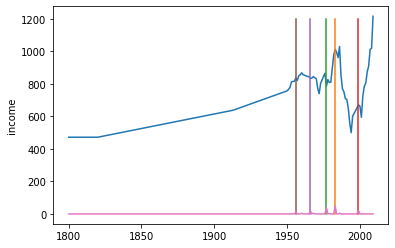

In [289]:
import matplotlib.pyplot as plt
import seaborn as sns
g = new_nations.groupby('name')
for k in g.groups.keys():
    df = g.get_group(k).sort_values('year').set_index('year').interpolate('time')
    break
sns.lineplot(x=range(1800, 2010), y='income', data=df)
p = peaks(df['income'], 5)
for x in np.argsort(p)[::-1][:5]:
    x += 1800
    plt.plot([x, x], [0, 1200])
sns.lineplot(range(1800, 2010), p)

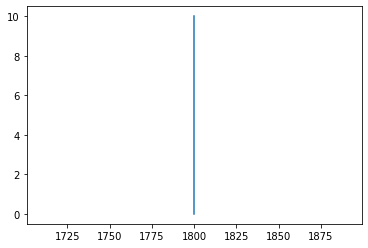

In [271]:
plt.plot([1800, 1800], [0, 10])

In [287]:
def c(ys):
    y_mean = np.mean(ys)
    return np.sum(np.abs(ys-y_mean))

def d(ys1, ys2):
    return c(pd.concat([ys1, ys2])) - c(ys1) - c(ys2)

def peaks(ys, window_size):
    ds = [0]
    for i in range(1, len(ys)-1):
        # この辺よくわからん
        if not (max(ys[i-1], ys[i+1]) < ys[i] or min(ys[i-1], ys[i+1]) > ys[i]):
            ds.append(0)
            continue
        ds.append(d(ys[max(0, i-window_size//2):i], ys[i:i+window_size//2]))
    # ds = [d(ys[max(0, i-window_size):i], ys[i:i+window_size]) for i in range(len(ys))]
    ds.append(0)
    return ds

def trend_changes(ys, window_size):
    grad_diff = []
    for i in range(len(ys)):

        
    xmean = x.mean(axis=axis, keepdims=True)
    xstd  = np.std(x, axis=axis, keepdims=True)
    pass


def grads(ys, window_size):
    grads = [get_grad(ys[max(0, i-window_size//2):i+window_size//2]) for i in range(len(ys))]
    return grads
    
    
def get_grad(ys):
    a, b = np.linalg.lstsq(np.array([[i, 1] for i in range(len(ys))]), np.array(ys))[0]
    return a




In [279]:
a, b = np.linalg.lstsq(np.array([[i, 1] for i in range(10)]), np.arange(10))[0]

(array([1.00000000e+00, 8.68083959e-16]),
 array([4.5829536e-30]),
 2,
 array([17.09316714,  1.68036813]))

In [280]:
np.linalg.lstsq?

Signature: np.linalg.lstsq(a, b, rcond='warn')
Docstring:
Return the least-squares solution to a linear matrix equation.

Solves the equation :math:`a x = b` by computing a vector `x` that
minimizes the squared Euclidean 2-norm :math:`\| b - a x \|^2_2`.
The equation may be under-, well-, or over-determined (i.e., the
number of linearly independent rows of `a` can be less than, equal
to, or greater than its number of linearly independent columns).
If `a` is square and of full rank, then `x` (but for round-off error)
is the "exact" solution of the equation.

Parameters
----------
a : (M, N) array_like
    "Coefficient" matrix.
b : {(M,), (M, K)} array_like
    Ordinate or "dependent variable" values. If `b` is two-dimensional,
    the least-squares solution is calculated for each of the `K` columns
    of `b`.
rcond : float, optional
    Cut-off ratio for small singular values of `a`.
    For the purposes of rank determination, singular values are treated
    as zero if they are smaller

In [256]:
pd.concat([df['income'][:10], df['income'][10:20]])

year
1800-01-01    472.05
1801-01-01    472.05
1802-01-01    472.05
1803-01-01    472.05
1804-01-01    472.05
1805-01-01    472.05
1806-01-01    472.05
1807-01-01    472.05
1808-01-01    472.05
1809-01-01    472.05
1810-01-01    472.05
1811-01-01    472.05
1812-01-01    472.05
1813-01-01    472.05
1814-01-01    472.05
1815-01-01    472.05
1816-01-01    472.05
1817-01-01    472.05
1818-01-01    472.05
1819-01-01    472.05
Name: income, dtype: float64

In [ ]:
import matplotlib.pyplot as plt 
import numpy as np 
from scipy.stats import norm 
  
# setting the values of 
# mean and S.D. 
mean = 0
SD = 1
  
# value of cdf between one, two 
# and three S.D. around the mean 
one_sd = norm.cdf(SD, mean, SD) - norm.cdf(-SD, mean, SD) 
two_sd = norm.cdf(2 * SD, mean, SD) - norm.cdf(-2 * SD, mean, SD) 
three_sd = norm.cdf(3 * SD, mean, SD) - norm.cdf(-3 * SD, mean, SD) 
  
# printing the value of fractions 
# within each band 
print("Fracton of values within one SD =", one_sd) 
print("Fracton of values within two SD =", two_sd) 
print("Fracton of values within three SD =", three_sd) 